In [1]:
import pandas as pd
import numpy as np
import pandasql as ps

import itertools
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Case

Imagine that you are studying the results of distributed data for an experiment on changing the sorting algorithm for hotels on a website at Ostrovok. 

**Major changes** have been made to the product funnel page as SERP.

The main goal of the launch was to prioritize specific hotel segments that are most accessible in search results in order to improve the partner experience.

**As a result**, you need to look at the data and answer the questions:

- What success metrics of the AB experiment would you suggest?
- Did we get any useful results over experiment launch?
- Do you have any recommendations for future investigations?

## Data
The file contains simulated data for a calculated data collection period to investigate the impact of changes in the availability sorting algorithm on the product.

In [3]:
DATASET_PATH = 'product_test_data'

In [4]:
df = pd.read_csv(DATASET_PATH, low_memory=False, sep='\t')

## Description of fields  

-- **Title** - Description  
-- **Index** - row index  
-- **group** - experiment group assigned to uuid  
-- **brand** - product brand name  
-- **landing_step** - landing funnel step  
-- **is_new** - new user marker  
-- **channel** - product entry channel  
-- **uuid** - user identifier  
-- **main_page_hit** - main page visit marker  
-- **serp_hit** - serp page visit marker  
-- **hotelpage_hit** - hotel page visit marker  
-- **booking_form_hit** - booking page visit marker  
-- **voucher_hit** - voucher get page visit marker  
-- **comission** - booking commission amount

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.set_index('index')

### General information about the data

In [6]:
df.head()

,main_page_hit,serp_hit,hotelpage_hit,booking_form_hit,voucher_hit,comission,channel,group,is_new,landing_step,uuid,brand
index,,,,,,,,,,,,
0,1.00,1.00,0.00,0.00,0.00,0.00,brand,control,False,main_page,39401fa4-7249-42ac-9acc-912e243b71b3,b2b.ostrovok.ru
1,1.00,1.00,0.00,0.00,0.00,0.00,brand,control,False,main_page,a70946f3-0108-4555-9b03-201dbe1431e8,b2b.ostrovok.ru
2,1.00,1.00,1.00,1.00,1.00,1683.08,brand,control,True,main_page,3bd904fc-d638-4194-bb99-f93945940832,b2b.ostrovok.ru
3,1.00,1.00,0.00,0.00,0.00,0.00,brand,control,True,main_page,83baf07d-d5f1-4beb-9039-6f04a981e190,b2b.ostrovok.ru
4,1.00,1.00,1.00,1.00,0.00,0.00,brand,control,False,main_page,b01a4a0e-a3c2-4c39-b53c-32b8d6e0b91b,b2b.ostrovok.ru


In [7]:
df.shape

(4819924, 12)

In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4819924 entries, 0 to 2409961
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   main_page_hit     4819724 non-null  float64
 1   serp_hit          4819724 non-null  float64
 2   hotelpage_hit     4819724 non-null  float64
 3   booking_form_hit  4819724 non-null  float64
 4   voucher_hit       4819724 non-null  float64
 5   comission         4819724 non-null  float64
 6   channel           4819724 non-null  object 
 7   group             4819724 non-null  object 
 8   is_new            4819724 non-null  object 
 9   landing_step      4817221 non-null  object 
 10  uuid              4819924 non-null  object 
 11  brand             4819924 non-null  object 
dtypes: float64(6), object(6)
memory usage: 478.1+ MB


**Unique Values**

In [9]:
df.nunique()

main_page_hit             2
serp_hit                  2
hotelpage_hit             2
booking_form_hit          2
voucher_hit               2
comission            122923
channel                   2
group                     2
is_new                    2
landing_step              2
uuid                4819525
brand                     2
dtype: int64

**Data Gaps**

In [10]:
df.isna().sum()

main_page_hit        200
serp_hit             200
hotelpage_hit        200
booking_form_hit     200
voucher_hit          200
comission            200
channel              200
group                200
is_new               200
landing_step        2703
uuid                   0
brand                  0
dtype: int64

**Value Counts**

In [11]:
for i in df.select_dtypes(include=['object', 'float64']).columns:
    print(str(i) + '\n\n' + str(df[i].value_counts()) + '\n' + '-' * 100 + '\n')

main_page_hit

1.00    4810192
0.00       9532
Name: main_page_hit, dtype: int64
----------------------------------------------------------------------------------------------------

serp_hit

1.00    3555558
0.00    1264166
Name: serp_hit, dtype: int64
----------------------------------------------------------------------------------------------------

hotelpage_hit

0.00    2803293
1.00    2016431
Name: hotelpage_hit, dtype: int64
----------------------------------------------------------------------------------------------------

booking_form_hit

0.00    4323115
1.00     496609
Name: booking_form_hit, dtype: int64
----------------------------------------------------------------------------------------------------

voucher_hit

0.00    4697368
1.00     122356
Name: voucher_hit, dtype: int64
----------------------------------------------------------------------------------------------------

comission

0.00       4696802
221.49           1
808.40           1
963.32           1
1156.3

## Solution

In [12]:
df = df[df['main_page_hit'] == 1]

In [13]:
df['landing_step'].value_counts()

main_page    4809992
Name: landing_step, dtype: int64

In [14]:
gr_df  = df.groupby(by='group', as_index=False).agg(
    group_cnt=pd.NamedAgg(column='uuid', aggfunc='count'),
    main_page_hit=pd.NamedAgg(column='main_page_hit', aggfunc='sum'),
    serp_hit=pd.NamedAgg(column='serp_hit', aggfunc='sum'),
    hotelpage_hit=pd.NamedAgg(column='hotelpage_hit', aggfunc='sum'),
    booking_form_hit=pd.NamedAgg(column='booking_form_hit', aggfunc='sum'),
    voucher_hit=pd.NamedAgg(column='voucher_hit', aggfunc='sum'),
    comission=pd.NamedAgg(column='comission', aggfunc='sum'),
)

gr_df

,group,group_cnt,main_page_hit,serp_hit,hotelpage_hit,booking_form_hit,voucher_hit,comission
0,control,2404880,2404880.00,1765308.00,1003105.00,246548.00,60346.00,59823001.45
1,test,2405112,2405112.00,1782927.00,1009198.00,249053.00,61769.00,61640773.53


In [15]:
gr_df['paying_users_cnt'] = [
    df[(df['group'] == 'control') & (df['booking_form_hit'] == 1) & (df['comission'] != 0 )].shape[0],
    df[(df['group'] == 'test') & (df['booking_form_hit'] == 1) & (df['comission'] != 0 )].shape[0],    
]

In [16]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

Let's calculate metrics:  
-- **CR** = Serp_hit / Booking_form_hit  
-- **ARPU** = Revenue / Quantity of Users  
-- **ARPPU** = Revenue / Quantity of Paying Users

In [17]:
gr_df['CR_serp_to_group_cnt'] = (gr_df['serp_hit'] / gr_df['group_cnt'])
gr_df['CR_booking_to_serp'] = (gr_df['booking_form_hit'] / gr_df['serp_hit'])

gr_df['CR_voucher_to_serp'] = (gr_df['voucher_hit'] / gr_df['serp_hit'])

gr_df['ARPU'] = gr_df['comission'] / gr_df['group_cnt']
gr_df['ARPPU'] = gr_df['comission'] / gr_df['paying_users_cnt']


gr_df[['group', 'CR_serp_to_group_cnt', 'CR_booking_to_serp', 'CR_voucher_to_serp', 'ARPU', 'ARPPU']]

,group,CR_serp_to_group_cnt,CR_booking_to_serp,CR_voucher_to_serp,ARPU,ARPPU
0,control,0.7341,0.1397,0.0342,24.8757,990.4962
1,test,0.7413,0.1397,0.0346,25.6291,997.7787


### All the values are increasing in a test group. 

- If we took as a Key Metrics ratio SERP to main page, we could see, that test is statistical significance on a confidence level 95%
- Additional metrics like ARPU, ARPPU are growing too

https://www.evanmiller.org/ab-testing/chi-squared.html

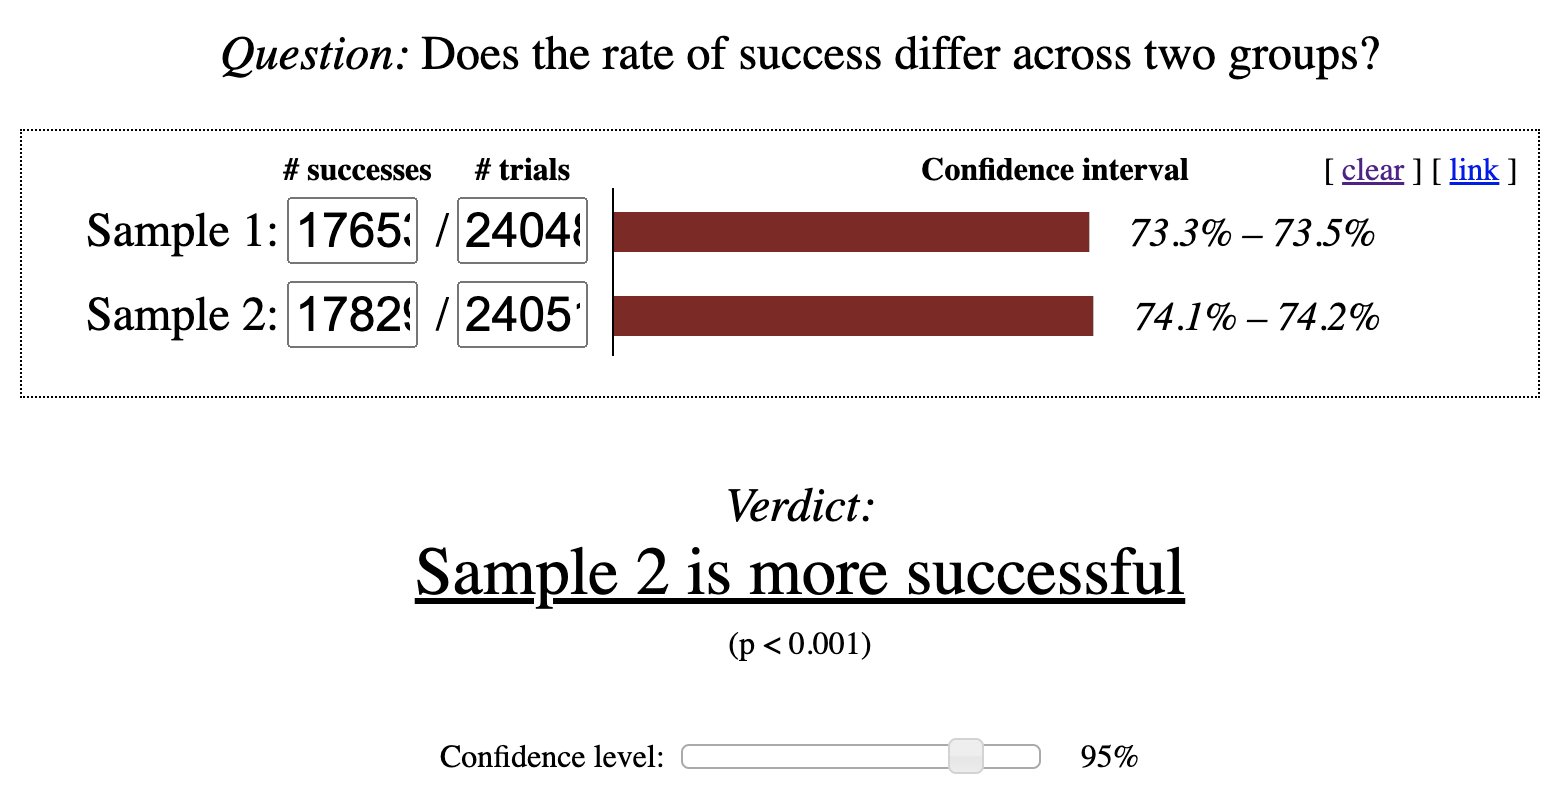

In [18]:
round(0.74131 / 0.73405, 2), round(0.13969 / 0.13966, 2), round(25.62907 / 24.87567, 2), round(997.77872 / 990.49624, 2)

(1.01, 1.0, 1.03, 1.01)